# Part I: Research Question
## A1
#### Using previous reviews on a product or service, can we predict if a user has a positive or negative opinion on it?
## A2
#### The goal of this analysis is to see if the words a user uses can predict the sentiment they have for a product or services.
## A3
#### Recurrent Neural Networks are used for text classification. RNN can produce text classifications such as sequence labeling, speech, tagging, and more. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow.keras
from keras.layers import Embedding
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
import statsmodels.api as sm
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import statistics

# Part II: Data Preparation

In [2]:
#Getting the files
amazon = pd.read_csv("C:/Users/cklni/Desktop/WGU/D213/Task 2/task 2 data/sentiment labelled sentences/amazon_cells_labelled.txt", sep="\t", header=None, names=["text", "label"])
imdb = pd.read_csv("C:/Users/cklni/Desktop/WGU/D213/Task 2/task 2 data/sentiment labelled sentences/imdb_labelled.txt", sep="\t", header=None, names=["text", "label"])
yelp = pd.read_csv("C:/Users/cklni/Desktop/WGU/D213/Task 2/task 2 data/sentiment labelled sentences/yelp_labelled.txt", sep="\t", header=None, names=["text", "label"])

#Concatenate
df = pd.concat((amazon, imdb, yelp), ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2748 non-null   object
 1   label   2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [3]:
#Check dataframe for shape
print('Shape of data:', df.shape)
df.head()

Shape of data: (2748, 2)


,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
#Rename Columns
df = df.rename(columns={'text': 'review', 'label': 'sentiment'})

## B1-1
#### Below is the code that is removing the presence of unusual characters.

In [5]:
#Making lowercase
df['review'] = df['review'].str.lower()

#Remove punctuation
df.review = df.review.str.replace(r'[^\w\s]+', '')
df.review = df.review.str.replace(r'\(.*\)', '', regex = True)
df.review = df.review.str.strip()

# Defining special characters
spec_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '?', '.']

# Replacing special characters with spaces
for char in spec_chars:
    df['review'] = df['review'].str.replace(re.escape(char), '')

In [6]:
#Length of review 
df['length_reviews'] = df.review.str.len()
df.head()

,review,sentiment,length_reviews
0,so there is no way for me to plug it in here i...,0,81
1,good case excellent value,1,25
2,great for the jawbone,1,21
3,tied to charger for conversations lasting more...,0,76
4,the mic is great,1,16


In [7]:
reviews = df['review'].tolist()
vocab = []
max_review_len = 0

for review in reviews:
    review_len = len(review.split(" "))
    if review_len > max_review_len:
        max_review_len = review_len

for word in review.split(" "):
    if not word in vocab:
        vocab.append(word)

print("Vocab:  ", len(vocab))
print("Longest:  ", max_review_len)
print("Emb Size:  ", len(vocab)**0.25)

Vocab:   26
Longest:   1390
Emb Size:   2.2581008643532257


## B1-2
#### The vocabulary size is 26.
## B1-3
#### The proposed word embedding length is 2.26.

In [8]:
commentary_length = []
for char_len in df['review']:
    commentary_length.append(len(char_len.split(' ')))
    
commentary_max = np.max(commentary_length)
commentary_min = np.min(commentary_length)
commentary_median = np.median(commentary_length)
commentary_75 = np.percentile(commentary_length, 75)

print("Max:", commentary_max)
print("Min:", commentary_min)
print("Median:", commentary_median)
print("75th percentile:", commentary_75)

Max: 1390
Min: 1
Median: 10.0
75th percentile: 16.0


## B1-4
#### I saw that the longest review length of 1390, which made me investigate the median and 75th percentile to get a better feel for the data. The 75th percentile of 16 in comparison to the max shows there is outliers. I will use 16 as the maximum sequence length to hopefully gain some accuracy in my model. 
## B2
#### The tokenization process assigns a number or “tokens” to each word. I will be using one hot from TensorFlow. Keras package to accomplish this.

In [9]:
encoded_reviews = [one_hot(d, len(vocab)) for d in reviews]
print(encoded_reviews[0])

[16, 21, 21, 14, 6, 9, 1, 4, 8, 10, 17, 23, 17, 12, 24, 24, 17, 4, 14, 8, 20]


## B3-1
#### The padding occurs after the text sequence.

In [10]:
max_review_len = 16  # Adjusted for 75th percentile
padded_reviews = pad_sequences(encoded_reviews, maxlen=max_review_len, padding='post')
print(padded_reviews)

[[ 9  1  4 ... 14  8 20]
 [ 7  3 25 ...  0  0  0]
 [11  9 12 ...  0  0  0]
 ...
 [ 9 17 20 ...  0  0  0]
 [12 17 13 ...  3 23 14]
 [11 14 17 ...  3 12 16]]


## B3-2
#### Please see below for a single padded sequence.

In [11]:
padded_reviews[1]

array([ 7,  3, 25,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

## B4
#### There is two categories of sentiment. Negative reviews are 0 and positive reviews are 1. 
## B5
#### I imported all the three files and concatenated them. I renamed the columns to give better meanings to them. Then I removed the unusual characters by making all lowercase, removing the punctuations, and replaced the special characters with spaces. I created a new column for the length of the reviews. Next, I got the vocabulary number, longest review, and the recommended embedding size. Then I tokenized the reviews and padded them to a max length of 16. Below I will split the data into 80/20 for the training and test sets.

In [12]:
#Split the dataset
x_train, x_test, y_train, y_test = train_test_split(padded_reviews, df.sentiment, test_size=0.2, random_state=7)

## B6
#### The below code is saving the prepared data set. This will be submitted with this notebook.

In [13]:
df_final = pd.DataFrame(padded_reviews)
df_final['sentiment'] = df.sentiment
df_final.to_csv("C:/Users/cklni/Desktop/WGU/D213/Task 2/christianleblancprepared.csv")

# Part III: Network Architecture
## C1
#### Please see below for the model summary.

In [58]:
model = keras.Sequential()
model.add(keras.layers.Embedding(27, 8, input_length=16))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model by providing an input shape
model.build(input_shape=(None, 16))

# Print the model summary
print(model.summary())


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ (None, 16, 8)               │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,297 (8.97 KB)

 Trainable params: 2,297 (8.97 KB)

 Non-trainable params: 0 (0.00 B)

None


In [61]:
score = model.evaluate(x_test, y_test, verbose = 0)

print('Test loss',res[0])
print('Test accuracy',res[1])

Test loss 0.6922975778579712
Test accuracy 0.5272727012634277


## C2
#### The model has five layers. The first layer is embedding with 216 parameters. The second layer is Flatten. The third is Dropout. The fourth and fifth layers are Dense. The fourth has 2,064 parameters and fifth has 17.
## C3-1
#### Both the Sigmoid function and the Rectified Linear Activation (ReLu) were used in the model. The Sigmoid function was used for its binary classification. The ReLu is efficient activation function used for hidden layers.
## C3-2
#### The first three layers have 128 nodes. The third has 16. The last layer has 1 node.
## C3-3
#### The loss function for the model is Binary crossentropy due to the binary responses of positive or negative reviews.
## C3-4
#### The “adam” optimizer is the optimizer for the model. It was chosen due to its performance and efficiency.
## C3-5
#### I will use a stopping criteria of patience of 2. This will be done to avoid overfitting of the training data.
## C3-6
#### Using the “accuracy” metric to evaluate the model gives a Test accuracy of approximately 52.7%. 
# Part IV: Model Evaluation

In [59]:
unrestricted = model.fit(x_train, y_train, epochs=30,
                    validation_data=[x_test, y_test])

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5237 - loss: 0.6919 - val_accuracy: 0.5109 - val_loss: 0.6929
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5733 - loss: 0.6888 - val_accuracy: 0.5073 - val_loss: 0.6904
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5911 - loss: 0.6809 - val_accuracy: 0.5582 - val_loss: 0.6853
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6100 - loss: 0.6715 - val_accuracy: 0.5782 - val_loss: 0.6790
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6279 - loss: 0.6591 - val_accuracy: 0.5873 - val_loss: 0.6723
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6390 - loss: 0.6432 - val_accuracy: 0.6000 - val_loss: 0.6707
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6477 - loss: 0.6339 - val_accuracy: 0.6127 - val_loss: 0.6691
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6416 - loss: 0.6292 - val_accuracy: 0.6000 - val_loss:

In [60]:
num_epochs = 30

early_stopping_monitor = EarlyStopping(patience=2)

history = model.fit(x_train, y_train, epochs=num_epochs,
                     validation_data=[x_test, y_test], callbacks=[early_stopping_monitor])

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6886 - loss: 0.5869 - val_accuracy: 0.6018 - val_loss: 0.6930
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6869 - loss: 0.5855 - val_accuracy: 0.5964 - val_loss: 0.6919
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7018 - loss: 0.5793 - val_accuracy: 0.6073 - val_loss: 0.6955
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7087 - loss: 0.5656 - val_accuracy: 0.5982 - val_loss: 0.6969


## D1
#### Above I ran a model fit with 30 epochs without any stopping criteria and then with a stopping criteria of 2 patience. The stopping criteria helped efficiency by dropping the number of epochs needed.
## D2
#### The training accuracy being approximately 10% higher than the validation and test accuracies shows some overfitting is present. This could possibly be improved by things such as a simpler model or having access to more data to improve the model’s ability to generalize.
## D3
#### Please see graphs below.

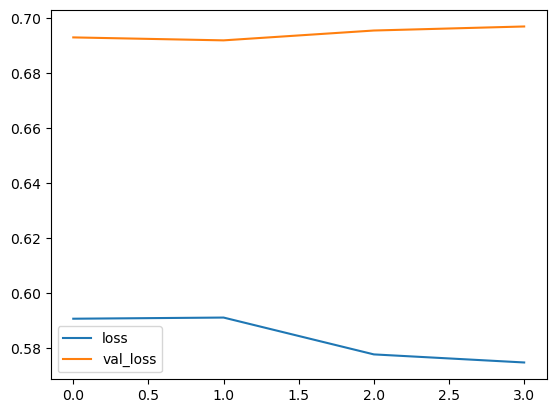

<Figure size 640x480 with 0 Axes>

In [62]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

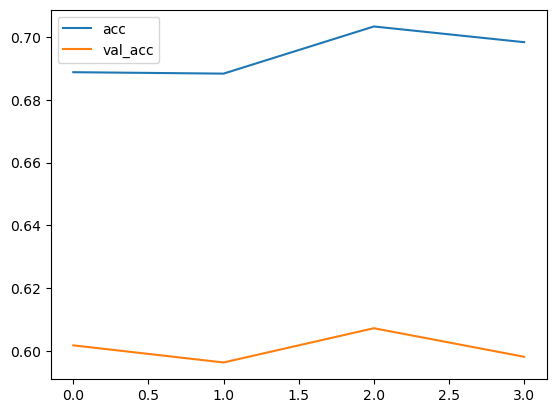

<Figure size 640x480 with 0 Axes>

In [63]:
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()
plt.savefig("accuracy plot.jpg")

## D4
#### The accuracy of the trained network after the 4th epoch is 70.9%. This is when the early stopping of patience equal to two stopped. The graph shows that the validation accuracy mirrors the rise and falls but it does it around 8-10% lower.
# Part V: Summary and Recommendations
## E
#### Please see below code used to save the trained network.

In [66]:
model.save('SentimentAnalysisModel.keras')

## F
#### The data given has 2,748 reviews. 80% of them were used to train the model and the other 20% were used to test the model. The network architecture enabled sentiment analysis by capturing contextual word dependencies and reducing overfitting. The network architecture comprises an embedding layer, a flattening layer, a dropout layer, and dense layers. This enables the model to classify reviews as positive or negative sentiment.
## G
#### I would recommend gathering more data to give more information to the model in the training data in hopes that it would cause the model to score a better accuracy especially in the test accuracy. In gaining more reviews I would assume that it would cause things such as the number of vocabulary to grow which would call for many changes in the model.
# Part VI: Reporting
## H
#### This notebook as a PDF that will be included in my submission.
## I
#### Web sources for code: 
#### https://www.tensorflow.org/tutorials/quickstart/beginner
#### https://westerngovernorsuniversity.sharepoint.com/:f:/r/sites/DataScienceTeam/Shared%20Documents/Graduate%20Team/D213/Student%20Facing%20Resources?csf=1&web=1&e=j0NEOf
## J
#### No in-text citations.
## K
#### The content in this Performance Assessment is set up and presented with the highest professional standards.

In [1]:
!jupyter nbconvert --to webpdf "Christian LeBlanc D213 Task 2 v4.ipynb" --allow-chromium-download

[NbConvertApp] Converting notebook Christian LeBlanc D213 Task 2 v4.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 319956 bytes to Christian LeBlanc D213 Task 2 v4.pdf
